<a href="https://colab.research.google.com/github/Strojove-uceni/23206-final-sudoku-solver/blob/main/DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sudoku solver

Authors: Filip Koňařík, Matěj Popďakunik

Abstract: In this project, we wrote a program that can solve Sudoku boards. First, we find the Sudoku in the image, then we use a CNN to recognize the individual digits, and finally, we solve it using a backtracking algorithm.

Methodology: In the final version of the project, we used a custom Convolutional Neural Network (CNN) to recognize individual digits, as it allowed us to achieve the best results.


# DEMO

## Imports and definitions of functions

In [65]:
!pip install torchmetrics --quiet
!pip install lightning --quiet
!pip install py-sudoku --quiet
!pip install gdown -- quiet

import cv2
import numpy as np
import operator
import os
from google.colab.patches import cv2_imshow
import json
import pandas as pd
import albumentations as A
from google.colab.patches import cv2_imshow
import typing
import itertools
import copy
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import WeightedRandomSampler
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from torchmetrics import ConfusionMatrix, Accuracy
import requests
from io import BytesIO
from PIL import Image
import gdown

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


### Download images and checkpoint for demo

# New section

# New section

# New section

In [95]:

def download(url, name):
  response = requests.get(url)

  print(response.content)
  if response.status_code == 200:
      # Open the image using PIL
      image = Image.open(BytesIO(response.content))

      # Save the image to a file
      image.save(name)
      print('Image downloaded and saved successfully.')
  else:
      print(f'Failed to download image. Status code: {response.status_code}')

gdown.download("https://drive.google.com/uc?id=16btmBuPJnnVXUDqqUiuzb4i-s8rfwIgf", "1.jpg")
gdown.download("https://drive.google.com/uc?id=1vQeGNuyXLr8qI206jD87B_YuzP56UZGT", "2.jpg")
gdown.download("https://drive.google.com/uc?id=11ZKoDf8MypwqTBzFkVoblnD5tdTQ8tE1", "3.jpg")


gdown.download("https://drive.google.com/uc?id=1IiCjS8LLXRseknFQV5XZPNRJEFjdVsGs", "digitCls.pt")



Downloading...
From: https://drive.google.com/uc?id=16btmBuPJnnVXUDqqUiuzb4i-s8rfwIgf
To: /content/1.jpg
100%|██████████| 34.7k/34.7k [00:00<00:00, 46.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vQeGNuyXLr8qI206jD87B_YuzP56UZGT
To: /content/2.jpg
100%|██████████| 27.3k/27.3k [00:00<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ZKoDf8MypwqTBzFkVoblnD5tdTQ8tE1
To: /content/3.jpg
100%|██████████| 79.6k/79.6k [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IiCjS8LLXRseknFQV5XZPNRJEFjdVsGs
To: /content/digitCls.pt
100%|██████████| 193k/193k [00:00<00:00, 58.4MB/s]


'digitCls.pt'

### Sudoku detection

In [67]:
# Find four corners of sudoku grid using OpenCV functions
def find_corners(sudoku_image):
  sudoku_image = cv2.cvtColor(sudoku_image, cv2.COLOR_BGR2GRAY)
  cv2.GaussianBlur(sudoku_image, (9, 9), 0, sudoku_image)
  cv2.adaptiveThreshold(sudoku_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2, sudoku_image)

  contours = cv2.findContours(sudoku_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  contours = sorted(contours, key=cv2.contourArea, reverse=True) #sort contours to fing the largest one
  largest_contour = contours[0]

  corners1 = largest_contour[:4].copy()
  corners2 = largest_contour[:4].copy()

  # Find corners of the sudoku
  # We for 2 squares and than check which square has larger area -> works also for rotated images
  for pt in largest_contour:
    if pt[0][0] + pt[0][1] < corners1[0][0][0] + corners1[0][0][1]: corners1[0] = pt
    if pt[0][0] - pt[0][1] > corners1[1][0][0] - corners1[1][0][1]: corners1[1] = pt
    if pt[0][0] + pt[0][1] > corners1[2][0][0] + corners1[2][0][1]: corners1[2] = pt
    if pt[0][0] - pt[0][1] < corners1[3][0][0] - corners1[3][0][1]: corners1[3] = pt
    if pt[0][0] < corners2[0][0][0]: corners2[0] = pt
    if pt[0][1] < corners2[1][0][1]: corners2[1] = pt
    if pt[0][0] > corners2[2][0][0]: corners2[2] = pt
    if pt[0][1] > corners2[3][0][1]: corners2[3] = pt
  if cv2.contourArea(corners1) > cv2.contourArea(corners2):
    return corners1.squeeze()
  else:
    return corners2.squeeze()

#### Example

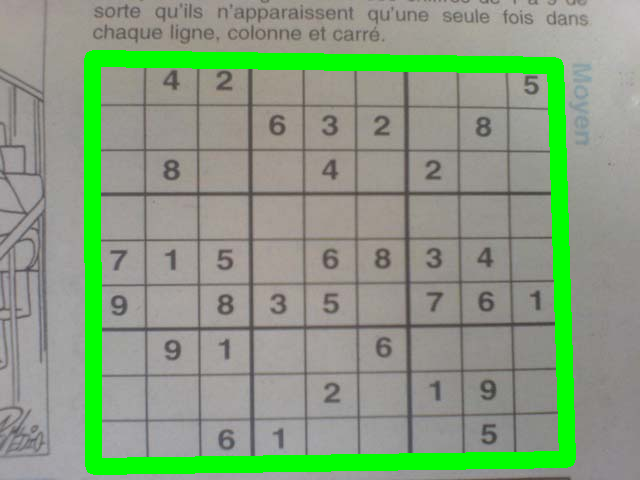

In [68]:
#testing
image = cv2.imread("1.jpg")
# cv2_imshow(image)
corners = find_corners(image)
cv2.drawContours(image, [corners], -1, (0,255,0), 15)
cv2_imshow(image)

### Digit classification


In [69]:
n_classes = 10

#class representing dataset of images of printed sudoku digits from photos
class SudokuNumberDataset(Dataset):
  def __init__(self, root_dir, csv_path, output_size, n_images_to_process=4000):
    self.sudoku_df = pd.read_csv(csv_path) #dataframe containing info about sudoku photos
    self.n_images = n_images_to_process*81 #number of digit images

    #create empty tensors to store digit images and labels in
    self.X = torch.empty((self.n_images, 1, output_size[0], output_size[1]))
    self.y = torch.empty(self.n_images, dtype=torch.long)

    #ids of images from the original dataset
    #images from data augmentation are stored consecutively so we want to sample across the whole dataset
    original_ids = np.linspace(0, 3999, n_images_to_process).astype(int)


    for id in range(n_images_to_process):
      #load greyscale images and corner keypoints
      img_name = os.path.join(root_dir, str(original_ids[id]) + ".jpg")
      image = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2GRAY)
      keypoints = np.array(self.sudoku_df.loc[original_ids[id]][4:]).reshape((4, 2)).astype("float32")

      grid_side = max([np.sqrt(p[0]*p[0] + p[1]*p[1]) for p in keypoints]) #find longes distance between corners

      #transform the sudoku image to a square
      keypoints_new = np.array([[0, 0], [grid_side - 1, 0], [grid_side - 1, grid_side - 1], [0, grid_side - 1]], dtype='float32')
      transform = cv2.getPerspectiveTransform(keypoints, keypoints_new)
      image = cv2.warpPerspective(image, transform, (int(grid_side), int(grid_side)))

      #cut the square sudoku image into images of individual cells
      cell_side = grid_side / 9
      for i in range(9):
        for j in range(9):
          top_left = (int(i * cell_side), int(j * cell_side))
          bottom_right = (int((i + 1) * cell_side), int((j + 1) * cell_side))
          number_image = image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
          number_image = cv2.resize(number_image, output_size)
          self.X[id*81 + i*9 + j] = torch.Tensor(number_image).unsqueeze(0)
          self.y[id*81 + i*9 + j] = torch.tensor(int(self.sudoku_df.loc[original_ids[id]]["nums"][i*9 + j]))

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
      return self.n_images

  #normalize the images
  def normalize(self, mean=None, std=None):
    if mean == None and std == None:
      mean = self.X.mean((0, 2, 3))[:, None, None]
      std = self.X.std((0, 2, 3))[:, None, None]
      print("Mean:", mean, "Std:", std)
      self.X = (self.X - mean) / std

In [70]:
#a convolutional neural network to classify digits from sudoku photos
class DigitClassifier(pl.LightningModule):
  def __init__(self, image_shape, learning_rate=0.1):
    super().__init__()
    self.loss_fn = nn.CrossEntropyLoss()
    self.learning_rate = learning_rate

    #convolutional part of the network
    self.cnn_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )

    conv_output_shape = (int(((image_shape[0] - 2) / 2 - 2) / 2),
                         int(((image_shape[1] - 2) / 2 - 2) / 2))
    #linear part of the network
    self.linear_layers = nn.Sequential(
        nn.Linear(in_features=conv_output_shape[0]*conv_output_shape[1]*24, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=n_classes)
        )

  def forward(self, x):
    y = self.cnn_layers(x)
    y = y.view(y.size(0), -1)
    y = self.linear_layers(y)
    y = F.softmax(y, dim=1)
    return y

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = self.loss_fn(y_hat, y)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.loss_fn(y_hat, y)
    accuracy = Accuracy(task="multiclass", num_classes=10).to("cuda:0")
    self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    self.log('acc', accuracy(y_hat, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def predict_step(self, batch, batch_idx):
    x, _ = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return SGD(self.parameters(), lr=self.learning_rate)

After training we get the following confusion matrix

|       | 0     | 1     | 2     | 3     | 4     | 5     | 6     | 7     | 8     | 9     |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| **0** | 10373 | 0     | 0     | 0     | 0     | 1     | 0     | 2     | 0     | 0     |
| **1** | 0     | 612   | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 0     |
| **2** | 0     | 0     | 683   | 0     | 0     | 0     | 0     | 1     | 0     | 0     |
| **3** | 1     | 0     | 0     | 679   | 0     | 0     | 0     | 0     | 0     | 0     |
| **4** | 0     | 0     | 0     | 0     | 625   | 0     | 0     | 0     | 0     | 0     |
| **5** | 0     | 1     | 0     | 2     | 2     | 629   | 2     | 0     | 0     | 0     |
| **6** | 0     | 0     | 0     | 0     | 0     | 0     | 564   | 0     | 0     | 1     |
| **7** | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 668   | 0     | 0     |
| **8** | 0     | 0     | 0     | 0     | 0     | 0     | 2     | 0     | 738   | 0     |
| **9** | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 0     | 614   |


As we can see, the network has a 99,6% accuracy.


### Image processing pipeline

In [97]:
def solve(image):
  mean = 139.445
  std = 37.7531

  #load digit classification model
  model = torch.jit.load('digitCls.pt')
  model.eval()

  #transform into greyscale
  sudoku_image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  sudoku_image = sudoku_image_grayscale.copy()

  #find contours
  cv2.GaussianBlur(sudoku_image, (9, 9), 0, sudoku_image)
  cv2.adaptiveThreshold(sudoku_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2, sudoku_image)
  contours = cv2.findContours(sudoku_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  #there are no contours, no sudoku found -> return empty string
  if len(contours) == 0:
    return ""

  contours = sorted(contours, key=cv2.contourArea, reverse=True) #sort contours to find the largest one
  largest_contour = contours[0]

  corners1 = largest_contour[:4].copy()
  corners2 = largest_contour[:4].copy()

  #find corners of the sudoku
  #we search for 2 squares and than check which square has larger area -> works also for rotated images
  for pt in largest_contour:
    if pt[0][0] + pt[0][1] < corners1[0][0][0] + corners1[0][0][1]: corners1[0] = pt
    if pt[0][0] - pt[0][1] > corners1[1][0][0] - corners1[1][0][1]: corners1[1] = pt
    if pt[0][0] + pt[0][1] > corners1[2][0][0] + corners1[2][0][1]: corners1[2] = pt
    if pt[0][0] - pt[0][1] < corners1[3][0][0] - corners1[3][0][1]: corners1[3] = pt
    if pt[0][0] < corners2[0][0][0]: corners2[0] = pt
    if pt[0][1] < corners2[1][0][1]: corners2[1] = pt
    if pt[0][0] > corners2[2][0][0]: corners2[2] = pt
    if pt[0][1] > corners2[3][0][1]: corners2[3] = pt

  #compare the areas
  corners = np.empty(0)
  if cv2.contourArea(corners1) > cv2.contourArea(corners2):
    corners = corners1.squeeze()
  else:
    corners = corners2.squeeze()

  grid_side = max([np.sqrt(p[0]*p[0] + p[1]*p[1]) for p in corners]) #find longes distance between corners

  #transform the sudoku image to a square
  corners_new = np.array([[0, 0], [grid_side - 1, 0], [grid_side - 1, grid_side - 1], [0, grid_side - 1]], dtype="float32")
  transform = cv2.getPerspectiveTransform(corners.astype("float32"), corners_new)
  sudoku_image_grayscale = cv2.warpPerspective(sudoku_image_grayscale, transform, (int(grid_side), int(grid_side)))

  #cut the square sudoku image into images of individual cells and recognize digits in cells
  output = ""
  cell_side = grid_side / 9
  for i in range(9):
    for j in range(9):
      top_left = (int(i * cell_side), int(j * cell_side))
      bottom_right = (int((i + 1) * cell_side), int((j + 1) * cell_side))
      number_image = sudoku_image_grayscale[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
      number_image = torch.Tensor(cv2.resize(number_image, (28, 28))).unsqueeze(0).unsqueeze(0)
      # cv2_imshow(np.array(number_image.detach().squeeze()))
      number_image = (number_image - mean) / std
      pred = str(np.array(model(number_image).argmax().detach()))
      # print(pred)
      output += pred
  return output #return recognized digits as a string


### Example

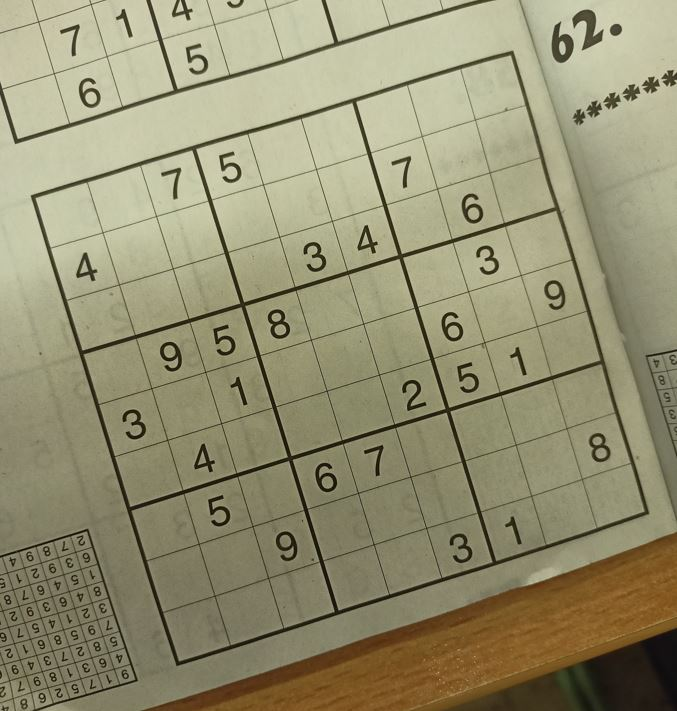

0 0 7 5 0 0 0 0 0 
4 0 0 0 0 0 7 0 0 
0 0 0 0 3 4 0 6 0 
0 9 5 8 0 0 0 3 0 
3 0 1 0 0 0 6 0 9 
0 4 0 0 0 2 5 1 0 
0 5 0 6 7 0 0 0 0 
0 0 9 0 0 0 0 0 8 
0 0 0 0 0 3 1 0 0 



In [98]:
image = cv2.imread("3.jpg")
cv2_imshow(image)
sudoku.load_from_string(solve(image))
print(sudoku)





### Recursive sudoku solver

In [165]:
class SudokuBoard():
  # creates empty board
  def __init__(self):
    self.board = [0]*9
    for i in range(9):
      self.board[i] = [0]*9

  def __str__(self) -> str:
    result = ""
    for row in self.board:
      for column in row:
        result = result + str(column) + " "
      result = result + "\n"
    return result

  def load_from_number(self, input : int) -> None:
    self.load_from_string(str(input))

  def load_from_string(self, input: str) -> None:
    temp = [s for s in input.split() if s.isdigit()]
    sanitized_string  = ''.join([str(x) for x in temp])
    if len(sanitized_string) != 81:
      raise RuntimeError("Invalid Sudoku Length")
    for i, character in enumerate(sanitized_string):
      self.board[i//9][i%9] = int(character)
    return self

  def is_invalid(self):
    # checks if any row or any column or any square contains 2 of the same number
    for row in range(9):
      temp = ''.join([str(x) for x in self.board[row]])
      temp = temp.replace("0", "")
      if len(temp) != len(set(temp)):
        return True

    for column in range(9):
      temp = ""
      for row in range(9):
        temp = temp + str(self.board[row][column])
      temp = temp.replace("0", "")
      if len(temp) != len(set(temp)):
        return True

    for square_row_index, square_column_index in itertools.product(range(3), range(3)):
      temp = ""
      for sub_row, sub_column in itertools.product(range(3), range(3)):
        temp = temp + str(self.board[square_row_index*3 + sub_row][square_column_index*3 + sub_column])
      temp = temp.replace("0", "")
      if len(temp) != len(set(temp)):
        return True
    return False

  def new_modified_board(self, row, column, new_char):
    new = SudokuBoard()
    new.board = copy.deepcopy(self.board)
    new.board[row][column] = new_char
    return new


  def solve(self):
    # Solves loaded Sudoku using backtracking (DFS)

    def find_empty_spot(board):
      for i in range(len(board)):
          for j in range(len(board[0])):
              if board[i][j] == 0:
                  return i, j  # row, column
      return None

    def solve_board(board):
      find = find_empty_spot(board)
      if not find:  # if find is None or False
        return True
      else:
        row, col = find

      for num in range(1, 10):
        if valid(board, num, (row, col)):
          board[row][col] = num

          if solve_board(board):
            return True

          board[row][col] = 0

      return False


    def valid(board, num, pos):
      # Checks row
      for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
          return False

      # Checks column
      for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
          return False

      # Checks box
      box_x = pos[1] // 3
      box_y = pos[0] // 3

      for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
          if board[i][j] == num and (i, j) != pos:
            return False
      return True

    solve_board(self.board)
    return self.board


#### Example

In this example you can see our recursive solver solving a sudoku.

The first grid that is printed is the input (0s mark the empty spaces). The second grid is the solved sudoku.

In [107]:
sudoku = SudokuBoard()
sudoku.load_from_string("000000000100004089008009174083906000006000007400007020004600090070008060000001300")

print("Input:")
print(sudoku)
sudoku.solve()
print("Solved sudoku:")
print(sudoku)



Input:
0 0 0 0 0 0 0 0 0 
1 0 0 0 0 4 0 8 9 
0 0 8 0 0 9 1 7 4 
0 8 3 9 0 6 0 0 0 
0 0 6 0 0 0 0 0 7 
4 0 0 0 0 7 0 2 0 
0 0 4 6 0 0 0 9 0 
0 7 0 0 0 8 0 6 0 
0 0 0 0 0 1 3 0 0 

Solved sudoku:
9 4 7 8 1 2 6 5 3 
1 3 5 7 6 4 2 8 9 
6 2 8 5 3 9 1 7 4 
7 8 3 9 2 6 4 1 5 
2 9 6 1 4 5 8 3 7 
4 5 1 3 8 7 9 2 6 
8 1 4 6 5 3 7 9 2 
3 7 2 4 9 8 5 6 1 
5 6 9 2 7 1 3 4 8 



#### Functions for presenting

# New section

In [155]:
def print_examples(img1, img2, img3):
  img1 = cv2.resize(img1, (400, 400), interpolation=cv2.INTER_CUBIC)
  img2 = cv2.resize(img2, (400, 400), interpolation=cv2.INTER_CUBIC)
  img3 = cv2.resize(img3, (400, 400), interpolation=cv2.INTER_CUBIC)

  if len(np.shape(img1)) == 2:
    padding = np.ones((400, 20))*255
  else:
    padding = np.ones((400, 20,3))*255
  stacked_images = np.hstack((img1, padding, img2, padding, img3))

  cv2_imshow(stacked_images)


def transformation(image):
  corners = find_corners(image)
  grid_side = max([np.sqrt(p[0]*p[0] + p[1]*p[1]) for p in corners])

  #transform the sudoku image to a square
  keypoints_new = np.array([[0, 0], [grid_side - 1, 0], [grid_side - 1, grid_side - 1], [0, grid_side - 1]], dtype='float32')
  transform = cv2.getPerspectiveTransform(corners.astype(np.float32), keypoints_new)
  return cv2.warpPerspective(image, transform, (int(grid_side), int(grid_side)))


In [142]:
def generate_image(board):
  def get_image_as_array(number):
    if number == None or number == 0:
      return np.invert(np.zeros((100,100), dtype = np.uint8))

    image = np.ones((100, 100, 1), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 4
    font_thickness = 3
    cv2.putText(image, str(number), (10, 90), font, font_scale, (0, 0, 0), font_thickness)

    x = image
    x = np.squeeze(x,2)
    return x

  def get_image_with_border(number):
    x = get_image_as_array(number)
    b = 5
    return cv2.copyMakeBorder(x, b,b,b,b, cv2.BORDER_CONSTANT, value=[122])

  def make_row(row):
    sequence = []
    for i in sudoku.board[row]:
      sequence.append(get_image_with_border(i))
    return np.hstack(tuple(sequence))

  def make_board():
    sequence = []
    for i in range(9):
      sequence.append(make_row(i))
    return np.vstack(tuple(sequence))

  return make_board()

## Showcase

First lets show the images, some of them appear squished because of having different aspect ratios:


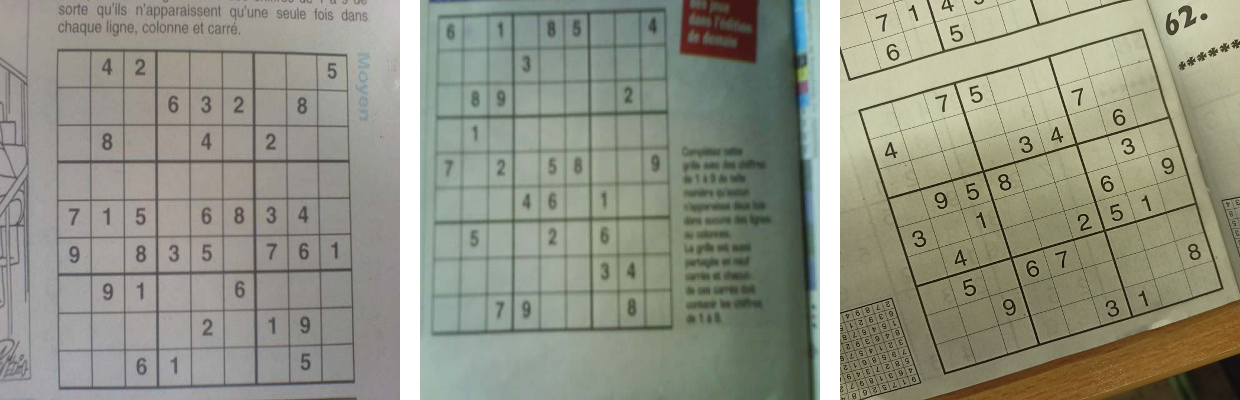

In [152]:
ex1 = cv2.imread("1.jpg")
ex2 = cv2.imread("2.jpg")
ex3 = cv2.imread("3.jpg")

print_examples(ex1, ex2, ex3)

Next we find the border of the sudoku:

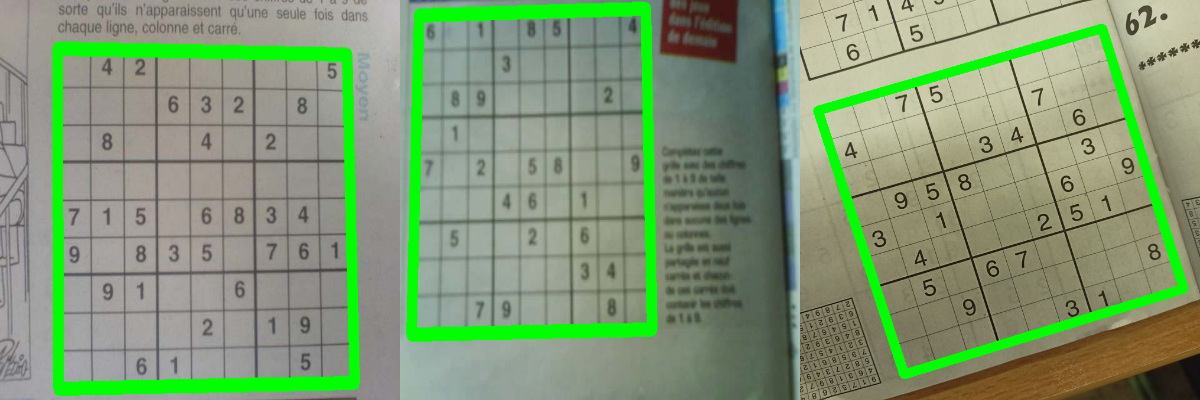

In [100]:
corners = find_corners(ex1)
cv2.drawContours(ex1, [corners], -1, (0,255,0), 15)

corners = find_corners(ex2)
cv2.drawContours(ex2, [corners], -1, (0,255,0), 15)

corners = find_corners(ex3)
cv2.drawContours(ex3, [corners], -1, (0,255,0), 15)

print_examples(ex1, ex2, ex3)


From the border we can find the transformation to turn the sudoku into a square. (We also reload the images to get rid of the corners)

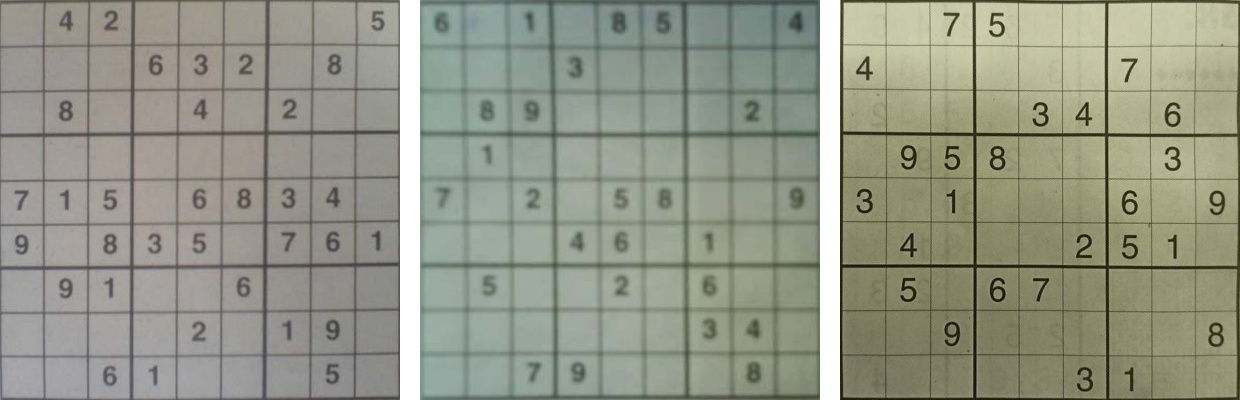

In [157]:
ex1 = cv2.imread("1.jpg")
ex2 = cv2.imread("2.jpg")
ex3 = cv2.imread("3.jpg")

print_examples(transformation(ex1), transformation(ex2), transformation(ex3))

Next we use the fact that the grid is equidistant and we segment the image, into 81 smaller squares. Next we detect the numbers in each square. For illustration, we redraw the sudoku board.

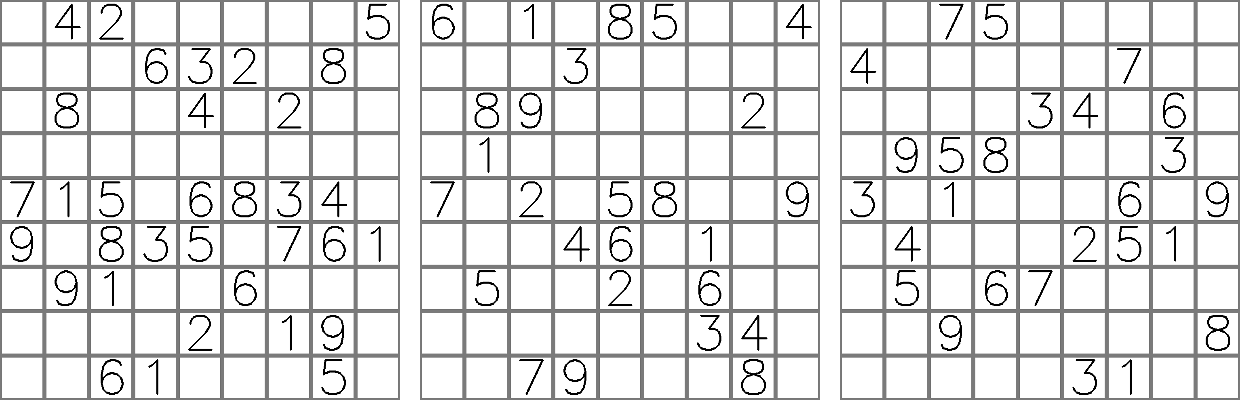

In [175]:
print_examples(
generate_image(sudoku.load_from_string(solve(ex1)).board),
generate_image(sudoku.load_from_string(solve(ex2)).board),
generate_image(sudoku.load_from_string(solve(ex3)).board),
)

Finally we solve the sudoku with bactracking.  And print the resulting sudoku.

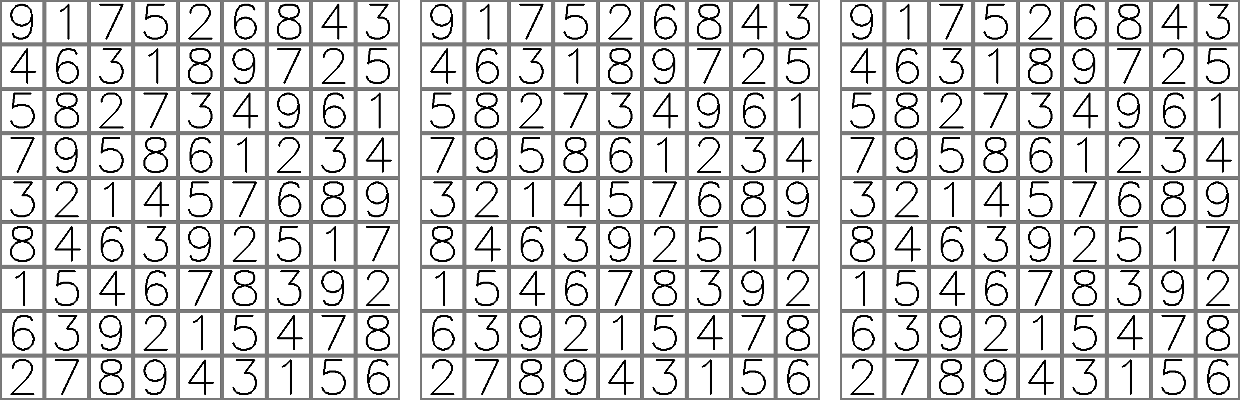

In [174]:
su1 = SudokuBoard()
su1.load_from_string(solve(ex1)).solve()
res1 = np.array(copy.deepcopy(su1.board))

su2 = SudokuBoard()
su2.load_from_string(solve(ex2)).solve()
res2 = np.array(copy.deepcopy(su2.board))

su3 = SudokuBoard()
su3.load_from_string(solve(ex3)).solve()
res3 = np.array(copy.deepcopy(su3.board))

print_examples(
generate_image(res1),
generate_image(res2),
generate_image(res3),
)